Trying to analyze the double descent of fitted models

In [212]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from simple_data import *
from sklearn import metrics
from tqdm import tqdm
import seaborn as sns
import pickle as pkl

In [200]:
def get_scores(model_type='linear', ns=None, ps=None, num_reps=25, noise_mults=[0.01, 0.1, 0.2]):
    if ns is None:
        ns = [100]
    if ps is None:
        ps = np.concatenate((np.arange(5, 500, 3), [750], [1000], [1500]))
    results_all = {}
    for n in ns:
        for noise_mult in noise_mults:

            results = {}
            train_scores = []
            test_scores = []
            wnorms = []
            pseudo_traces = []
            cov_traces = []
            nuclear_norms = []
            for p in tqdm(ps):
                X, y = get_data(n, p, noise_mult=noise_mult)
                
                train_mse, test_mse, wnorm, pseudo_trace, cov_trace, nuclear_norm = 0, 0, 0, 0, 0, 0
                try:
                    for reps in range(num_reps):
                        train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=reps)
                        model = LinearRegression()
                        model.fit(train_X, train_y)

                        train_pred = model.predict(train_X)
                        train_mse += metrics.mean_squared_error(train_pred, train_y)
                        test_pred = model.predict(test_X)
                        test_mse += metrics.mean_squared_error(test_pred, test_y)    
                        wnorm += np.linalg.norm(model.coef_)
                        inv = np.linalg.pinv(train_X.T @ train_X)
                        pseudo_trace += np.trace(inv)
                        cov_trace += np.trace(train_X.T @ train_X)
                        nuclear_norm += np.linalg.norm(inv, ord='nuc')
                except:
                    train_mse, test_mse, wnorm, pseudo_trace, cov_trace, nuclear_norm = np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

                train_scores.append(train_mse / num_reps)
                test_scores.append(test_mse / num_reps)        
                wnorms.append(wnorm / num_reps)
                pseudo_traces.append(pseudo_trace / num_reps)
                cov_traces.append(cov_trace / num_reps)
                nuclear_norms.append(nuclear_norm / num_reps)

            train_scores = np.array(train_scores)
            test_scores = np.array(test_scores)
            results = {'ps': np.array(ps), 'ns': np.array(ns) * 0.75, 
                       'train_scores': train_scores, 'test_scores': test_scores, 
                       'wnorms': wnorms, 'pseudo_traces': pseudo_traces, 
                       'cov_traces': cov_traces, 'nuclear_norms': nuclear_norms}
            results_all[noise_mult] = results
    return results_all

# linear reg in high dim

In [ ]:
ns_orig = [250]
ps = np.concatenate((np.arange(25, 200, 1), np.arange(200, 300, 1), np.arange(300, 500, 25), [750], [1000], [1500]))
noise_mults = [0.1] #[0.01, 0.1, 0.2]
num_reps = 1
results_all = get_scores(model_type='linear', ns=ns_orig, noise_mults=[0.1], num_reps=num_reps, ps=ps)

num nan 21
num nan 21


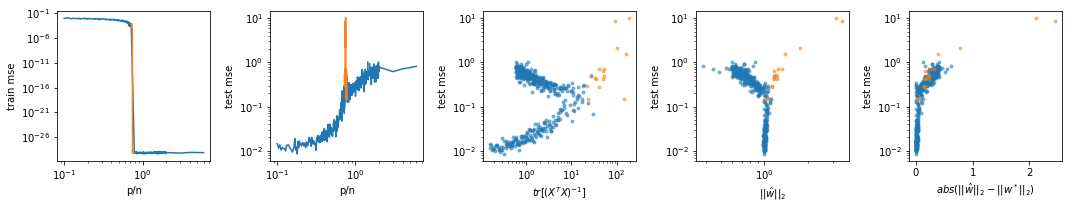

In [239]:
R, C = 1, 5
plt.figure(figsize=(C * 3, R * 3)) #, dpi=300)
# for n in ns_orig:
for i, noise_mult in enumerate(noise_mults):
    r = results_all[noise_mult]
    ps, ns, train_scores, test_scores, wnorms, pseudo_traces, cov_traces, nuclear_norms = \
    r['ps'], r['ns'], r['train_scores'], r['test_scores'], np.array(r['wnorms']), np.array(r['pseudo_traces']), np.array(r['cov_traces']), np.array(r['nuclear_norms'])
    
    # select what to paint
    for color in range(2):
        idxs = (ps/n < 0.72) + (ps/n > 0.78)
        if color == 1:
            idxs = ~idxs

        num_points = ps.size
        plt.subplot(R, C, 1)
        plt.plot((ps / n)[idxs], train_scores[idxs], label=f'noise_mult={noise_mult}')
        plt.xlabel('p/n')
        plt.ylabel('train mse')
        plt.yscale('log')
        plt.xscale('log')
    #     plt.legend()

        plt.subplot(R, C, 2)
        plt.plot((ps / n)[idxs], test_scores[idxs], '-')
        print('num nan', np.sum(np.isnan(test_scores)))
        plt.xlabel('p/n')
        plt.ylabel('test mse')
        plt.yscale('log')
        plt.xscale('log')

        plt.subplot(R, C, 3)
    #     if i == 2:
        plt.plot(pseudo_traces[idxs], test_scores[idxs], '.', alpha=0.5) #, c=np.arange(num_points)) #'red')
#         plt.plot(cov_traces[idxs], test_scores[idxs], '.', alpha=0.5) #, c=np.arange(num_points)) #'red')
#         plt.plot(nuclear_norms[idxs], test_scores[idxs], '.', alpha=0.5) #, c=np.arange(num_points)) #'red')    

        plt.xlabel('$tr[(X^TX)^{-1}]$')
        plt.ylabel('test mse')
        plt.yscale('log')
        plt.xscale('log')    

        plt.subplot(R, C, 4)
        plt.plot(wnorms[idxs], test_scores[idxs], '.', alpha=0.5)
        plt.xlabel('$||\hat{w}||_2$')
        plt.ylabel('test mse')
        plt.yscale('log')
        plt.xscale('log')

        plt.subplot(R, C, 5)
        plt.plot(np.abs(np.array(wnorms) - 1)[idxs], test_scores[idxs], '.', alpha=0.5)
        plt.xlabel('$abs(||\hat{w}||_2 - ||w^*||_2)$')
        plt.ylabel('test mse')
        plt.yscale('log')
    #     plt.xscale('log') 

plt.tight_layout()
plt.show()

In [169]:
# pkl.dump(results_all, open('./double_descent.pkl', 'wb'))